# MINERIA DE DATOS - TUIA - 2024
## Trabajo práctico N° 2
### Estudiante: Yañez, Mirian

### El siguiente trabajo se realiza con los conjuntos de datos "1000_Companies.csv" y "PokemonDB.csv"

### Instalo las dependencias necesarias

In [94]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  GridSearchCV
from sklearn.tree import export_text
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score



## Carga del dataset 1000 Companies

In [95]:
data = pd.read_csv('data/1000_Companies.csv')

### Información del dataset (datos nulos y tipos de datos por columna)

In [96]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   RyD_Spend       1000 non-null   float64
 1   Administration  1000 non-null   float64
 2   MarketingSpend  1000 non-null   float64
 3   State           1000 non-null   object 
 4   Profit          1000 non-null   float64
dtypes: float64(4), object(1)
memory usage: 39.2+ KB


### Descripción estadística de los datos (min, max, media, mediana, etc.)

In [97]:
data.describe()

,RyD_Spend,Administration,MarketingSpend,Profit
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,81668.927200,122963.897612,226205.058419,119546.164656
std,46537.567891,12613.927535,91578.393542,42888.633848
min,0.000000,51283.140000,0.000000,14681.400000
25%,43084.500000,116640.684850,150969.584600,85943.198543
50%,79936.000000,122421.612150,224517.887350,117641.466300
75%,124565.500000,129139.118000,308189.808525,155577.107425
max,165349.200000,321652.140000,471784.100000,476485.430000


# Matriz de correlación

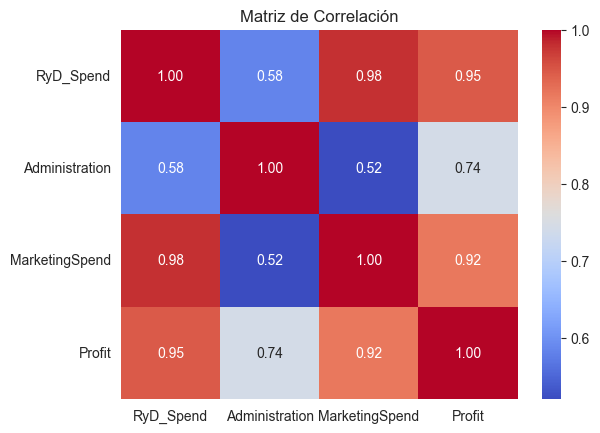

In [98]:
columnas_numericas = data.select_dtypes(include='number')

matriz_correlacion = columnas_numericas.corr()

sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', fmt=".2f")
plt.ylim(len(matriz_correlacion), 0)
plt.xlim(0, len(matriz_correlacion))
plt.title("Matriz de Correlación")
plt.show()

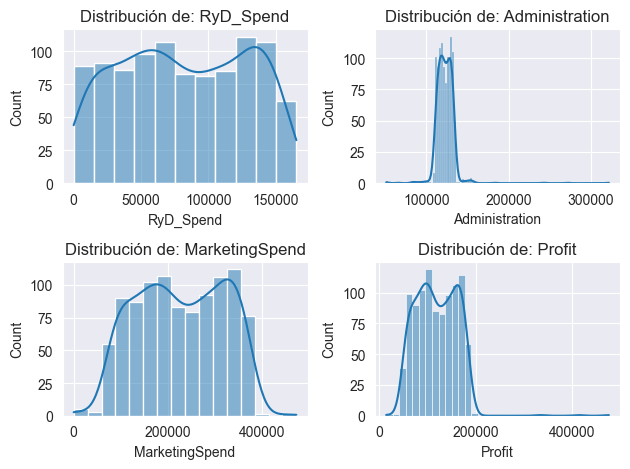

In [99]:
for i, column in enumerate(data.select_dtypes(include=['float64', 'int64']).columns):
    plt.subplot(2, 2, i + 1)
    sns.histplot(data[column], kde=True)
    plt.title(f'Distribución de: {column}')
plt.tight_layout()
plt.show()

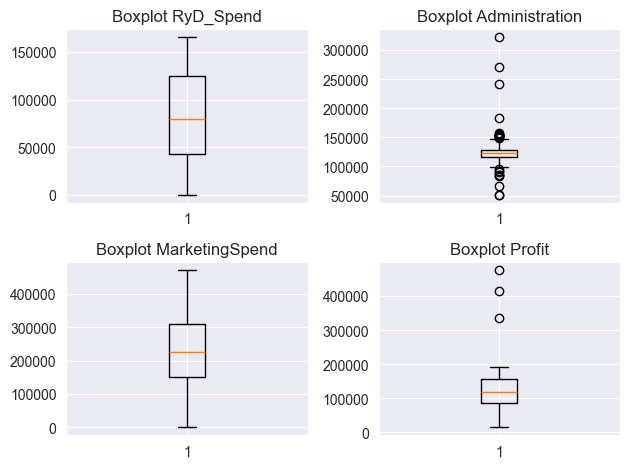

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

In [100]:
for i, column in enumerate(data.select_dtypes(include=['float64', 'int64']).columns):
    plt.subplot(2, 2, i + 1)
    plt.boxplot(data[column])
    plt.title(f'Boxplot {column}')

plt.tight_layout()
plt.show()
plt.figure(figsize=(12, 8))

## Outliers

In [101]:
def cantidad_outliers(column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers_count = ((data[column] < lower_bound) | (data[column] > upper_bound)).sum()
    return outliers_count

In [102]:
for column in columnas_numericas:
    outliers_count = cantidad_outliers(column)
    print(f'Cantidad de outliers en la columna {column}: {outliers_count}, porcentaje de outliers: {outliers_count*100/data.shape[0]} %')


Cantidad de outliers en la columna RyD_Spend: 0, porcentaje de outliers: 0.0 %
Cantidad de outliers en la columna Administration: 22, porcentaje de outliers: 2.2 %
Cantidad de outliers en la columna MarketingSpend: 0, porcentaje de outliers: 0.0 %
Cantidad de outliers en la columna Profit: 3, porcentaje de outliers: 0.3 %


## Dado que la cantidad de valores outliers representa menos del 3% total de los datos los elimino

In [103]:
def eliminar_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filtrar el dataframe para excluir los outliers
    data_cleaned = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    return data_cleaned

# Iterar sobre las columnas numéricas y eliminar outliers
for column in columnas_numericas:
    data = eliminar_outliers(data, column)

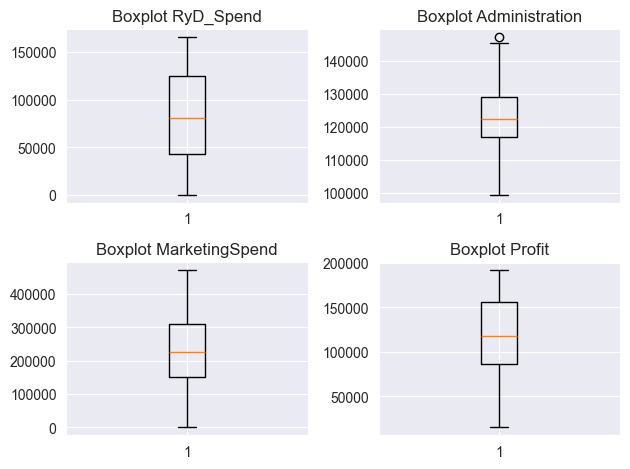

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

In [104]:
for i, column in enumerate(data.select_dtypes(include=['float64', 'int64']).columns):
    plt.subplot(2, 2, i + 1)
    plt.boxplot(data[column])
    plt.title(f'Boxplot {column}')

plt.tight_layout()
plt.show()
plt.figure(figsize=(12, 8))

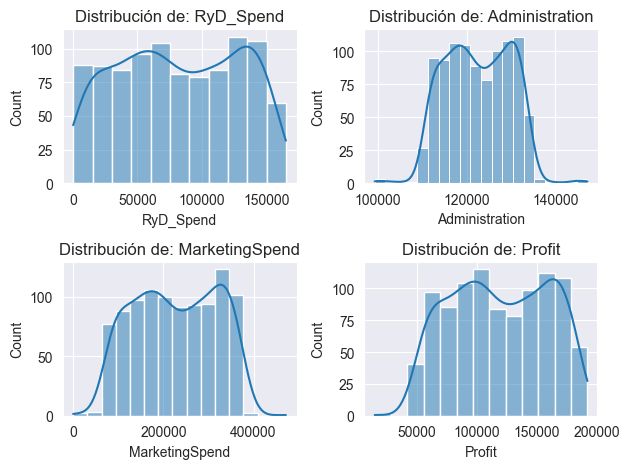

In [105]:
for i, column in enumerate(data.select_dtypes(include=['float64', 'int64']).columns):
    plt.subplot(2, 2, i + 1)
    sns.histplot(data[column], kde=True)
    plt.title(f'Distribución de: {column}')
plt.tight_layout()
plt.show()

# Estandarización

### Debido a que elimine los outliers y que los datos no presentan una distribucion gausiana, elijo el metodo minmax para realizar la estandarización 

In [106]:
columns_num= ['RyD_Spend', 'Administration', 'MarketingSpend', 'Profit']
scaler = MinMaxScaler()
data_scaler = scaler.fit_transform(data[columns_num])
data_scaled_df = pd.DataFrame(data_scaler, columns=columns_num)

## Regression Tree

### División train-test

In [107]:
y = data_scaled_df['Profit']
X = data_scaled_df.drop('Profit', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = tree.DecisionTreeRegressor(max_depth=6,min_samples_leaf=1, min_samples_split=2, random_state=13 )

regressor_tree = clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

feature_list = list(X_train.columns)

r = export_text(regressor_tree, feature_names=feature_list)
print(r)

|--- RyD_Spend <= 0.50
|   |--- RyD_Spend <= 0.25
|   |   |--- RyD_Spend <= 0.13
|   |   |   |--- RyD_Spend <= 0.07
|   |   |   |   |--- Administration <= 0.25
|   |   |   |   |   |--- Administration <= 0.24
|   |   |   |   |   |   |--- value: [0.20]
|   |   |   |   |   |--- Administration >  0.24
|   |   |   |   |   |   |--- value: [0.22]
|   |   |   |   |--- Administration >  0.25
|   |   |   |   |   |--- MarketingSpend <= 0.41
|   |   |   |   |   |   |--- value: [0.24]
|   |   |   |   |   |--- MarketingSpend >  0.41
|   |   |   |   |   |   |--- value: [0.20]
|   |   |   |--- RyD_Spend >  0.07
|   |   |   |   |--- Administration <= 0.28
|   |   |   |   |   |--- Administration <= 0.28
|   |   |   |   |   |   |--- value: [0.26]
|   |   |   |   |   |--- Administration >  0.28
|   |   |   |   |   |   |--- value: [0.26]
|   |   |   |   |--- Administration >  0.28
|   |   |   |   |   |--- Administration <= 0.29
|   |   |   |   |   |   |--- value: [0.28]
|   |   |   |   |   |--- Administrat

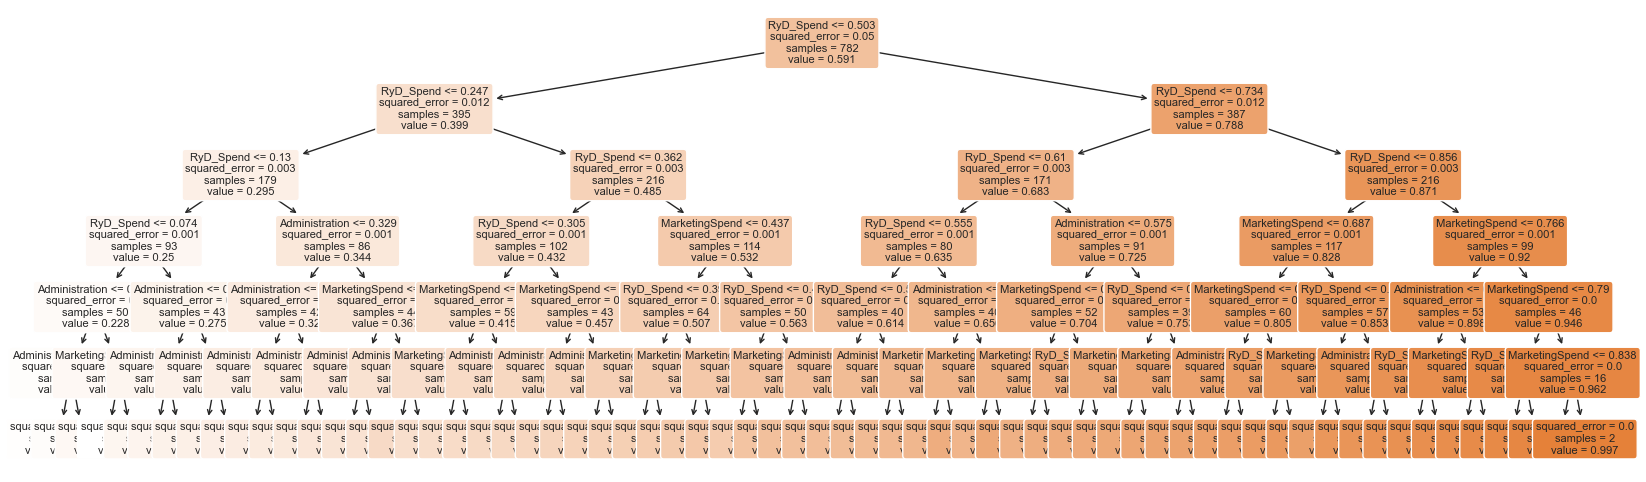

In [108]:
features = feature_list

plt.figure(figsize=(20,6))
tree.plot_tree(regressor_tree,
                feature_names=features,
                fontsize=8,
                filled=True,
                rounded=True)
plt.show()

# Métricas

In [109]:
y_test = y_test.astype(float)

mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions) # medida de la bondad de ajuste del modelo

#primero calculamos el error absoluto porcentual (APE) para cada predicción y luego calculamos el MAPE promediando estos errores.
mape = np.mean(np.abs((y_test - predictions) / y_test) * 100)
# Calcular R-squared adjusted (R2 ajustado)
n = len(y_test)  # Número de observaciones
p = len(feature_list)  # Número de predictores (variables independientes)
r2_adjusted = 1 - ((1 - r2) * (n - 1) / (n - p - 1))  # tiene en cuenta la complejidad del modelo al penalizar el uso excesivo de predictores
rmse = np.sqrt(mse)

# Imprimir MAPE
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2):", r2)
print("R-squared adjusted (R2 ajustado):", r2_adjusted)
print("Root Mean Squared Error (RMSE):", rmse)



Mean Absolute Percentage Error (MAPE): inf
Mean Absolute Error (MAE): 0.005412255389906947
Mean Squared Error (MSE): 0.0003556141398587484
Root Mean Squared Error (RMSE): 0.018857734218583853
R-squared (R2): 0.9931894708896826
R-squared adjusted (R2 ajustado): 0.9930830563723338
Root Mean Squared Error (RMSE): 0.018857734218583853


# Optimización de hiperparámetros

In [110]:
# Define un rango de hiperparámetros para la búsqueda en cuadrícula
param_grid = {
    'max_depth': [1, 2, 3],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Mejores hiperparámetros: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [111]:
y_test = y_test.astype(float)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred) # medida de la bondad de ajuste del modelo

#primero calculamos el error absoluto porcentual (APE) para cada predicción y luego calculamos el MAPE promediando estos errores.
mape = np.mean(np.abs((y_test - y_pred) / y_test) * 100)
# Calcular R-squared adjusted (R2 ajustado)
n = len(y_test)  # Número de observaciones
p = len(feature_list)  # Número de predictores (variables independientes)
r2_adjusted = 1 - ((1 - r2) * (n - 1) / (n - p - 1))  # tiene en cuenta la complejidad del modelo al penalizar el uso excesivo de predictores
rmse = np.sqrt(mse)

# Imprimir MAPE
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2):", r2)
print("R-squared adjusted (R2 ajustado):", r2_adjusted)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Percentage Error (MAPE): inf
Mean Absolute Error (MAE): 0.025957341107016387
Mean Squared Error (MSE): 0.0011603611298280738
Root Mean Squared Error (RMSE): 0.034064073887720384
R-squared (R2): 0.9777773930577848
R-squared adjusted (R2 ajustado): 0.9774301648243127
Root Mean Squared Error (RMSE): 0.034064073887720384


In [112]:
tableResult = pd.DataFrame({'Actual':y_test, 'Predicted':predictions})
tableResult.head()

,Actual,Predicted
199,0.223105,0.216527
543,0.467572,0.464718
174,0.346591,0.352569
928,0.828367,0.825335
66,0.707040,0.710594


In [113]:
r = export_text(best_model, feature_names=feature_list)
print(r)

|--- RyD_Spend <= 0.50
|   |--- RyD_Spend <= 0.25
|   |   |--- RyD_Spend <= 0.13
|   |   |   |--- value: [0.25]
|   |   |--- RyD_Spend >  0.13
|   |   |   |--- value: [0.34]
|   |--- RyD_Spend >  0.25
|   |   |--- RyD_Spend <= 0.36
|   |   |   |--- value: [0.43]
|   |   |--- RyD_Spend >  0.36
|   |   |   |--- value: [0.53]
|--- RyD_Spend >  0.50
|   |--- RyD_Spend <= 0.73
|   |   |--- RyD_Spend <= 0.61
|   |   |   |--- value: [0.63]
|   |   |--- RyD_Spend >  0.61
|   |   |   |--- value: [0.73]
|   |--- RyD_Spend >  0.73
|   |   |--- RyD_Spend <= 0.86
|   |   |   |--- value: [0.83]
|   |   |--- RyD_Spend >  0.86
|   |   |   |--- value: [0.92]



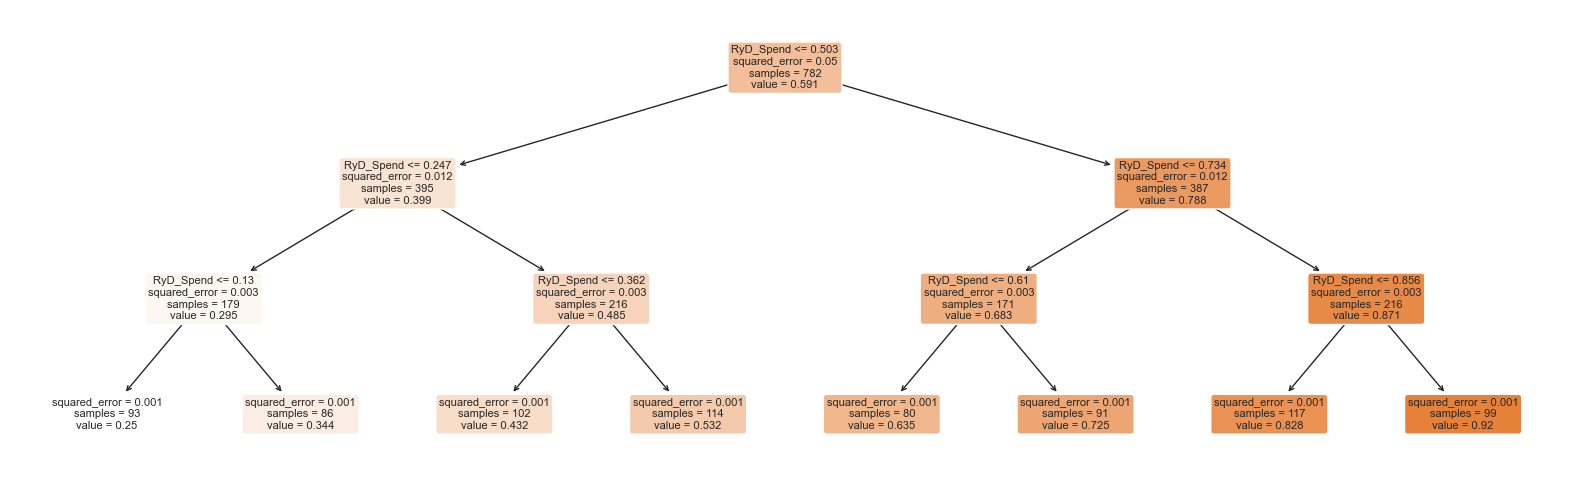

In [114]:
features = feature_list

plt.figure(figsize=(20,6))
tree.plot_tree(best_model,
                feature_names=features,
                fontsize=8,
                filled=True,
                rounded=True)
plt.show()

# Conclusión


.

# Dataset de Pokemon

In [115]:
df = pd.read_csv('data/PokemonDB2.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'data/PokemonDB2.csv'

In [ ]:
df

### Información del dataset (datos nulos y tipos de datos por columna)

In [ ]:
df.info()

### Descripción estadística de los datos (min, max, media, mediana, etc.)

In [ ]:
df.describe()

In [ ]:
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(12, 10))
for i, column in enumerate(numeric_columns):
    plt.subplot(3, 2, i + 1)
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribución de: {column}')
plt.tight_layout()
plt.show()

### Matriz de correlación

In [ ]:
columnas_numericas = df.select_dtypes(include='number')
matriz_correlacion = columnas_numericas.corr()

sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', fmt=".2f")
plt.ylim(len(matriz_correlacion), 0)
plt.xlim(0, len(matriz_correlacion))
plt.title("Matriz de Correlación")
plt.show()

In [ ]:
for i, column in enumerate(data.select_dtypes(include=['float64', 'int64']).columns):
    plt.subplot(3, 2, i + 1)
    plt.boxplot(data[column])
    plt.title(f'Boxplot {column}')

plt.tight_layout()
plt.show()
plt.figure(figsize=(12, 8))

### Se observa presencia de valores outliers, a continuación investigo a que pokemon pertenecen para poder realizar un mejor anaálisis
### Reviso los datos que aparentan ser outliers en la columna HP

In [ ]:
# Calcular el rango intercuartílico (IQR)
Q1 = df['HP'].quantile(0.25)
Q3 = df['HP'].quantile(0.75)
IQR = Q3 - Q1

# Definir los límites para los valores atípicos
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrar los valores atípicos
outliers = df[(df['HP'] < lower_bound) | (df['HP'] > upper_bound)]

print("Valores atípicos en la columna 'HP':")
print(outliers)


### Revise los datos de los Pokemon que aparentan ser outliers comparandolos con los del sitio web https://www.wikidex.net/wiki/Ferropalmas y son datos correctos

In [ ]:
type_counts = df['Type'].value_counts()

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))  # Tamaño opcional del gráfico
type_counts.plot(kind='bar', color='skyblue')

# Personalizar el gráfico
plt.title('Cantidad de cada tipo de Pokémon')
plt.xlabel('Tipo')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45, ha='right')  # Rotar las etiquetas del eje x para mayor legibilidad

# Mostrar el gráfico
plt.tight_layout()  # Ajustar el diseño para evitar que se corten las etiquetas
plt.show()

### Se puede observar que hay un alto nivel de desbalanceo entre las diferentes categorías.

In [ ]:
df_train, df_test,  = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
# Extraer las etiquetas (variable objetivo) de la columna 'Type' en los DataFrames 'df_train' y 'df_test', y convertirlas en arreglos NumPy.
train_labels = np.array(df_train['Type'])
test_labels = np.array(df_test['Type'])

# Elimino las etiquetas para separar las características (variables independientes) de la variable objetivo.
df_train = df_train.drop(['Type', 'Name'], axis = 1)
df_test = df_test.drop(['Type', 'Name'], axis = 1)

# Lista de nombres de características extrayendo los nombres de columna del DataFrame 'df_train' para usarlos luego.
feature_list = list(df_train.columns)

# Convierte los DataFrames modificados (sin la columna 'Type') es decir, las características (variables independientes) a array.
train_features = np.array(df_train)
test_features = np.array(df_test)

In [ ]:
clf = tree.DecisionTreeClassifier()

In [ ]:
#Entreno el modelo pasando las características de entrenamiento (train_features) y las etiquetas de entrenamiento correspondientes (train_labels).
decision_tree = clf.fit(train_features, train_labels)

# Predicción en el conjunto de entrenamiento
clf_predictions_train = clf.predict(train_features)

# Predicción en el conjunto de prueba
clf_predictions = clf.predict(test_features)

In [ ]:
from sklearn.metrics import accuracy_score
#Evaluo el rendimiento del modelo
train_accuracy = accuracy_score(train_labels, clf_predictions_train)
test_accuracy = accuracy_score(test_labels, clf_predictions)

In [ ]:
print('train_accuracy: ', train_accuracy, 'test_accuracy: ', test_accuracy)


### El modelo ajusta muy bien en el conjunto de entrenamiento pero un valor muy inferior en el conjunto de prueba, es probable que esté sobreajustando (overfitting) los datos de entrenamiento.

In [ ]:
from sklearn.tree import export_text
r = export_text(decision_tree, feature_names=feature_list)
print(r)

In [ ]:

features = feature_list

plt.figure(figsize=(20,6))
tree.plot_tree(decision_tree,
                feature_names=features,
                fontsize=8,
                filled=True,
                rounded=True)
plt.show()

### Optimización de hiperparámetros

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
# max_depth: La profundidad máxima del árbol.
# max_features: El número máximo de características a considerar para cada división. Suele ser la raíz cuadrada del número de características.
# min_samples_split: El número mínimo de muestras necesarias para dividir un nodo interno.
# random_state: Semilla para la generación de números aleatorios.

param_grid = {
    'max_features': [3, 5, 6, 7, 9],
    'max_depth': [6, 9, 10, 11],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'random_state': [42]
}
random_search = RandomizedSearchCV(tree.DecisionTreeClassifier(),
                                   param_grid)
random_search.fit(train_features, train_labels)
first_best_params = random_search.best_params_ # Mejores hiperparámetros encontrados durante la búsqueda aleatoria
best_prediction = random_search.predict(test_features) #Entrenamos el modelo con estos hiperparametros

test_accuracy = accuracy_score(test_labels, best_prediction)

precision = precision_score(test_labels, best_prediction, average='weighted', zero_division=0)

# Calcular la exhaustividad del modelo
recall = recall_score(test_labels, best_prediction, average='weighted')

# Calcular la exactitud del modelo
accuracy = accuracy_score(test_labels, best_prediction)

# Mostrar las métricas
print(f'Precisión del modelo: {precision}')
print(f'Exhaustividad del modelo: {recall}')
print(f'Exactitud del modelo: {accuracy}')


In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt



test_features1, test_features2, test_labels1, test_labels2 = train_test_split(test_features, test_labels, test_size=0.5, random_state=42)



# Calcular las métricas sobre el primer conjunto de prueba
predictions_test1 = random_search.predict(test_features1)
precision_test1 = precision_score(test_labels1, predictions_test1, average='weighted', zero_division=0)
recall_test1 = recall_score(test_labels1, predictions_test1, average='weighted')
accuracy_test1 = accuracy_score(test_labels1, predictions_test1)

# Calcular las métricas sobre el segundo conjunto de prueba
predictions_test2 = random_search.predict(test_features2)
precision_test2 = precision_score(test_labels2, predictions_test2, average='weighted', zero_division=0)
recall_test2 = recall_score(test_labels2, predictions_test2, average='weighted')
accuracy_test2 = accuracy_score(test_labels2, predictions_test2)

# Mostrar las métricas
print("Métricas sobre el primer conjunto de prueba:")
print(f'Precisión: {precision_test1}')
print(f'Exhaustividad: {recall_test1}')
print(f'Exactitud: {accuracy_test1}')
print("\nMétricas sobre el segundo conjunto de prueba:")
print(f'Precisión: {precision_test2}')
print(f'Exhaustividad: {recall_test2}')
print(f'Exactitud: {accuracy_test2}')

# Graficar el árbol obtenido durante el proceso de entrenamiento
plt.figure(figsize=(20, 10))
plot_tree(random_search.best_estimator_, feature_names=feature_list, filled=True, rounded=True)
plt.show()


# Metricas

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [ ]:
accuracy = accuracy_score(test_labels, clf_predictions)
precision = precision_score(test_labels, clf_predictions, average='macro')
recall = recall_score(test_labels, clf_predictions, average='macro')
f1 = f1_score(test_labels, clf_predictions, average='macro')
confusion = confusion_matrix(test_labels, clf_predictions)


In [ ]:
print(f'Accuracy: {accuracy},\n\nPrecision: {precision},\n\nRecall: {recall},\n\nF1 {f1}')


## Bayes Ingenuo

Vamos a probar GaussianNB en primer lugar, porque no requiere discretizar los datos y puede manejar características continuas como las obtenidas luego de estandarizar

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

# Dividir el conjunto de datos en entrenamiento y prueba
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

# Extraer etiquetas de clase
train_labels = np.array(df_train['Type'])
test_labels = np.array(df_test['Type'])

# Eliminar las etiquetas para separar las características
df_train = df_train.drop(['Type', 'Name'], axis=1)
df_test = df_test.drop(['Type', 'Name'], axis=1)

# Lista de nombres de características
feature_list = list(df_train.columns)

# Convertir los DataFrames a arrays
train_features = np.array(df_train)
test_features = np.array(df_test)

# Codificar etiquetas de clase
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Entrenar el modelo GaussianNB
model_GaussianNB = GaussianNB()
model_GaussianNB.fit(train_features, train_labels_encoded)

# Realizar predicciones en el conjunto de prueba
y_pred_GNB = model_GaussianNB.predict(test_features)
y_train_GNB = model_GaussianNB.predict(train_features)
# Crear la matriz de confusión
cm_GNB = metrics.confusion_matrix(test_labels_encoded, y_pred_GNB)

# Visualizar la matriz de confusión
metrics.ConfusionMatrixDisplay(confusion_matrix=cm_GNB).plot()


In [ ]:
# Calcular precision, exactitud y recuperación
precision = precision_score(test_labels_encoded, y_pred_GNB, average='weighted', zero_division=0)
accuracy = accuracy_score(test_labels_encoded, y_pred_GNB)
recall = recall_score(test_labels_encoded, y_pred_GNB, average='weighted', zero_division=0)

# Mostrar las métricas
print(f'Precision: {precision}')
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')


# K-NN

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=3)
# Entrenar el modelo
knn_model.fit(train_features, train_labels_encoded)

In [ ]:
predictions = knn_model.predict(test_features)
accuracy = accuracy_score(test_labels_encoded, predictions)
recall = recall_score(test_labels_encoded, predictions, average='weighted', zero_division=0)
print(f'Precision: {precision}')
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')

# KNN & GridSearchCV

In [ ]:
# Inicializar el clasificador KNN
knn_model_GSCV = KNeighborsClassifier()

# Definir los parámetros a ajustar
parametros_grid = {'n_neighbors':  range(1, 15, 2),
                   'p':[1,2],
                   'weights': ['uniform', 'distance'] }

# Inicializar el objeto GridSearchCV
grid_search = GridSearchCV(estimator = knn_model_GSCV,
                           param_grid = parametros_grid,
                           cv=5,
                           scoring='accuracy')

# Realizar la búsqueda de hiperparámetros en el conjunto de entrenamiento
grid_search.fit(train_features, train_labels_encoded)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", grid_search.best_params_)

# Obtener el mejor modelo entrenado
mejor_modelo = grid_search.best_estimator_

In [ ]:
# Realizar predicciones en el conjunto de prueba
predictions = mejor_modelo.predict(test_features)
accuracy = accuracy_score(test_labels_encoded, predictions)
recall = recall_score(test_labels_encoded, predictions, average='weighted', zero_division=0)
print(f'Precision: {precision}')
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')



## Conclusiones: 
En este análisis, exploramos varios modelos de clasificación, incluyendo Árbol de Decisión, Bayes Ingenuo y k-NN, con el propósito de predecir la variable "Type" en un conjunto de datos estandarizado. Nos enfocamos en la optimización de hiperparámetros para mejorar las métricas de rendimiento de cada modelo.

Uno de los principales hallazgos fue la importancia de abordar el desbalanceo en las clases de la variable objetivo. Aunque no aplicamos ninguna técnica de balanceo en este análisis, es crucial reconocer que enfrentar el desbalanceo podría ser beneficioso para mejorar el rendimiento de los modelos, especialmente en situaciones donde las clases están desproporcionadamente representadas en los datos.

Es posible que nuestras métricas de rendimiento más bajas se deban a la cantidad limitada de datos y al desbalanceo existente entre las clases. 
Ademas notamos mejores resultados en accuracy y recall cuando optimizamos los hiper paramtros.